<a href="https://colab.research.google.com/github/LoniQin/deep_learning_notebooks/blob/master/tensorflow/MNIST_WGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Packages

In [58]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import json
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, save_img, img_to_array
from functools import partial

## Defining WGAN class

In [59]:
class WGAN():
    def __init__(self
        , input_dim
        , critic_conv_filters
        , critic_conv_kernel_size
        , critic_conv_strides
        , critic_batch_norm_momentum
        , critic_activation
        , critic_dropout_rate
        , critic_learning_rate
        , generator_initial_dense_layer_size
        , generator_upsample
        , generator_conv_filters
        , generator_conv_kernel_size
        , generator_conv_strides
        , generator_batch_norm_momentum
        , generator_activation
        , generator_dropout_rate
        , generator_learning_rate
        , optimiser
        , z_dim
        ):

        self.name = 'gan'

        self.input_dim = input_dim
        self.critic_conv_filters = critic_conv_filters
        self.critic_conv_kernel_size = critic_conv_kernel_size
        self.critic_conv_strides = critic_conv_strides
        self.critic_batch_norm_momentum = critic_batch_norm_momentum
        self.critic_activation = critic_activation
        self.critic_dropout_rate = critic_dropout_rate
        self.critic_learning_rate = critic_learning_rate

        self.generator_initial_dense_layer_size = generator_initial_dense_layer_size
        self.generator_upsample = generator_upsample
        self.generator_conv_filters = generator_conv_filters
        self.generator_conv_kernel_size = generator_conv_kernel_size
        self.generator_conv_strides = generator_conv_strides
        self.generator_batch_norm_momentum = generator_batch_norm_momentum
        self.generator_activation = generator_activation
        self.generator_dropout_rate = generator_dropout_rate
        self.generator_learning_rate = generator_learning_rate
        
        self.optimiser = optimiser

        self.z_dim = z_dim

        

        self.n_layers_critic = len(critic_conv_filters)
        self.n_layers_generator = len(generator_conv_filters)

        self.weight_init = RandomNormal(mean=0., stddev=0.02)

        self.d_losses = []
        self.g_losses = []

        self.epoch = 0

    
        self._build_critic()
        self._build_generator()

        self._build_adversarial()

    def wasserstein(self, y_true, y_pred):
        return - K.mean(y_true * y_pred)

    def get_activation(self, activation):
        if activation == 'leaky_relu':
            layer = LeakyReLU(alpha = 0.2)
        else:
            layer = Activation(activation)
        return layer

    def _build_critic(self):

        ### THE critic
        critic_input = Input(shape=self.input_dim, name='critic_input')

        x = critic_input

        for i in range(self.n_layers_critic):

            x = Conv2D(
                filters = self.critic_conv_filters[i]
                , kernel_size = self.critic_conv_kernel_size[i]
                , strides = self.critic_conv_strides[i]
                , padding = 'same'
                , name = 'critic_conv_' + str(i)
                , kernel_initializer = self.weight_init
                )(x)

            if self.critic_batch_norm_momentum and i > 0:
                x = BatchNormalization(momentum = self.critic_batch_norm_momentum)(x)

            x = self.get_activation(self.critic_activation)(x)

            if self.critic_dropout_rate:
                x = Dropout(rate = self.critic_dropout_rate)(x)

        x = Flatten()(x)

        critic_output = Dense(1, activation=None
        , kernel_initializer = self.weight_init
        )(x)

        self.critic = Model(critic_input, critic_output)



    def _build_generator(self):

        ### THE generator

        generator_input = Input(shape=(self.z_dim,), name='generator_input')

        x = generator_input

        x = Dense(np.prod(self.generator_initial_dense_layer_size)
        ,kernel_initializer = self.weight_init
        )(x)

        
        if self.generator_batch_norm_momentum:
            x = BatchNormalization(momentum = self.generator_batch_norm_momentum)(x)

        x = self.get_activation(self.generator_activation)(x)

        x = Reshape(self.generator_initial_dense_layer_size)(x)

        if self.generator_dropout_rate:
            x = Dropout(rate = self.generator_dropout_rate)(x)

        for i in range(self.n_layers_generator):

            if self.generator_upsample[i] == 2:
                x = UpSampling2D()(x)
                x = Conv2D(
                filters = self.generator_conv_filters[i]
                , kernel_size = self.generator_conv_kernel_size[i]
                , padding = 'same'
                , name = 'generator_conv_' + str(i)
                , kernel_initializer = self.weight_init
                )(x)
            else:

                x = Conv2DTranspose(
                    filters = self.generator_conv_filters[i]
                    , kernel_size = self.generator_conv_kernel_size[i]
                    , padding = 'same'
                    , strides = self.generator_conv_strides[i]
                    , name = 'generator_conv_' + str(i)
                    , kernel_initializer = self.weight_init
                    )(x)

            if i < self.n_layers_generator - 1:

                if self.generator_batch_norm_momentum:
                    x = BatchNormalization(momentum = self.generator_batch_norm_momentum)(x)

                x = self.get_activation(self.generator_activation)(x)
            
            else:
                x = Activation('tanh')(x)


        generator_output = x

        self.generator = Model(generator_input, generator_output)


    def get_opti(self, lr):
        if self.optimiser == 'adam':
            opti = Adam(lr=lr, beta_1=0.5)
        elif self.optimiser == 'rmsprop':
            opti = RMSprop(lr=lr)
        else:
            opti = Adam(lr=lr)

        return opti

    def set_trainable(self, m, val):
        m.trainable = val
        for l in m.layers:
            l.trainable = val


    def _build_adversarial(self):
        
        ### COMPILE critic

        self.critic.compile(
            optimizer=self.get_opti(self.critic_learning_rate) 
            , loss = self.wasserstein
        )
        
        ### COMPILE THE FULL GAN

        self.set_trainable(self.critic, False)

        model_input = Input(shape=(self.z_dim,), name='model_input')
        model_output = self.critic(self.generator(model_input))
        self.model = Model(model_input, model_output)
        
        self.model.compile(
            optimizer=self.get_opti(self.generator_learning_rate)
            , loss=self.wasserstein
            )

        self.set_trainable(self.critic, True)



    
    def train_critic(self, x_train, batch_size, clip_threshold, using_generator):

        valid = np.ones((batch_size,1))
        fake = -np.ones((batch_size,1))

        if using_generator:
            true_imgs = next(x_train)[0]
            if true_imgs.shape[0] != batch_size:
                true_imgs = next(x_train)[0]
        else:
            idx = np.random.randint(0, x_train.shape[0], batch_size)
            true_imgs = x_train[idx]
        
        
        noise = np.random.normal(0, 1, (batch_size, self.z_dim))
        gen_imgs = self.generator.predict(noise)

        d_loss_real =   self.critic.train_on_batch(true_imgs, valid)
        d_loss_fake =   self.critic.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * (d_loss_real + d_loss_fake)

        for l in self.critic.layers:
            weights = l.get_weights()
            weights = [np.clip(w, -clip_threshold, clip_threshold) for w in weights]
            l.set_weights(weights)

        return [d_loss, d_loss_real, d_loss_fake]

    def train_generator(self, batch_size):
        valid = np.ones((batch_size,1))
        noise = np.random.normal(0, 1, (batch_size, self.z_dim))
        return self.model.train_on_batch(noise, valid)


    def train(self, x_train, batch_size, epochs, run_folder, print_every_n_batches = 10
        , n_critic = 5
        , clip_threshold = 0.01
        , using_generator = False):

        for epoch in range(self.epoch, self.epoch + epochs):

            for _ in range(n_critic):
                d_loss = self.train_critic(x_train, batch_size, clip_threshold, using_generator)

            g_loss = self.train_generator(batch_size)
               
            # Plot the progress
            
            self.d_losses.append(d_loss)
            self.g_losses.append(g_loss)

            # If at save interval => save generated image samples
            if epoch % print_every_n_batches == 0:
                print ("%d [D loss: (%.3f)(R %.3f, F %.3f)]  [G loss: %.3f] " % (epoch, d_loss[0], d_loss[1], d_loss[2], g_loss))
                self.sample_images(run_folder)
                self.model.save_weights(os.path.join(run_folder, 'weights/weights-%d.h5' % (epoch)))
                self.model.save_weights(os.path.join(run_folder, 'weights/weights.h5'))
                self.save_model(run_folder)
            
            self.epoch+=1

    def sample_images(self, run_folder):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.z_dim))
        gen_imgs = self.generator.predict(noise)

        #Rescale images 0 - 1

        gen_imgs = 0.5 * (gen_imgs + 1)
        gen_imgs = np.clip(gen_imgs, 0, 1)

        fig, axs = plt.subplots(r, c, figsize=(15,15))
        cnt = 0

        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(np.squeeze(gen_imgs[cnt, :,:,:]), cmap = 'gray_r')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig(os.path.join(run_folder, "images/sample_%d.png" % self.epoch))
        plt.close()

    def plot_model(self, run_folder):
        plot_model(self.model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.critic, to_file=os.path.join(run_folder ,'viz/critic.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.generator, to_file=os.path.join(run_folder ,'viz/generator.png'), show_shapes = True, show_layer_names = True)



            
    def save(self, folder):

            with open(os.path.join(folder, 'params.pkl'), 'wb') as f:
                pickle.dump([
                    self.input_dim
                    , self.critic_conv_filters
                    , self.critic_conv_kernel_size
                    , self.critic_conv_strides
                    , self.critic_batch_norm_momentum
                    , self.critic_activation
                    , self.critic_dropout_rate
                    , self.critic_learning_rate
                    , self.generator_initial_dense_layer_size
                    , self.generator_upsample
                    , self.generator_conv_filters
                    , self.generator_conv_kernel_size
                    , self.generator_conv_strides
                    , self.generator_batch_norm_momentum
                    , self.generator_activation
                    , self.generator_dropout_rate
                    , self.generator_learning_rate
                    , self.optimiser
                    , self.z_dim
                    ], f)

            self.plot_model(folder)

    def save_model(self, run_folder):
        self.model.save(os.path.join(run_folder, 'model.h5'))
        self.critic.save(os.path.join(run_folder, 'critic.h5'))
        self.generator.save(os.path.join(run_folder, 'generator.h5'))

    def load_weights(self, filepath):
        self.model.load_weights(filepath)

## Creating necessary folders

In [60]:
# run params
data_path = "/content/drive/MyDrive/data"
section = 'gan'
run_id = '0004'
data_name = 'mnist'
run_folder = data_path + '/{}/'.format(section)
run_folder += '_'.join([run_id, data_name])

if not os.path.exists(run_folder):
    os.mkdir(run_folder)
    os.mkdir(os.path.join(run_folder, 'viz'))
    os.mkdir(os.path.join(run_folder, 'images'))
    os.mkdir(os.path.join(run_folder, 'weights'))

## Loading the data
Now we load the mnist data and resize it to 

In [61]:
batch_size = 64
image_width = 32

In [62]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [63]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
train_imgs = []
for i in range(x_train.shape[0]):
  train_imgs.append(tf.image.resize(x_train[i, :, :], [image_width, image_width]))
images = np.array(train_imgs)
print(images.shape)

(60000, 32, 32, 1)


In [66]:
data_gen = ImageDataGenerator(preprocessing_function=lambda x: (x.astype('float32') - 127.5) / 127.5)
x_train = data_gen.flow(
    x=images,
    y=y_train,
    batch_size = batch_size, 
    shuffle = True
)


Help on method flow in module tensorflow.python.keras.preprocessing.image:

flow(x, y=None, batch_size=32, shuffle=True, sample_weight=None, seed=None, save_to_dir=None, save_prefix='', save_format='png', subset=None) method of tensorflow.python.keras.preprocessing.image.ImageDataGenerator instance
    Takes data & label arrays, generates batches of augmented data.
    
    Arguments:
        x: Input data. Numpy array of rank 4 or a tuple. If tuple, the first
          element should contain the images and the second element another numpy
          array or a list of numpy arrays that gets passed to the output without
          any modifications. Can be used to feed the model miscellaneous data
          along with the images. In case of grayscale data, the channels axis of
          the image array should have value 1, in case of RGB data, it should
          have value 3, and in case of RGBA data, it should have value 4.
        y: Labels.
        batch_size: Int (default: 32).
    

## Displaying random image

In [79]:
x_train[0][0][1].shape

(32, 32, 1)

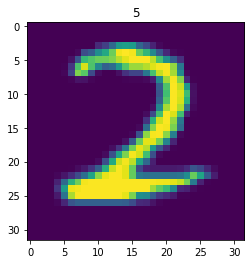

In [81]:
index = np.random.randint(0, images.shape[0])
plt.imshow(x_train[0][0][0].reshape(image_width, image_width))

## Building the Model

In [82]:
gan = WGAN(input_dim = (image_width,image_width,1)
            , critic_conv_filters = [image_width,image_width * 2,image_width * 4,image_width * 4]
            , critic_conv_kernel_size = [5,5,5,5]
            , critic_conv_strides = [2,2,2,1]
            , critic_batch_norm_momentum = None
            , critic_activation = 'leaky_relu'
            , critic_dropout_rate = None
            , critic_learning_rate = 0.00005
            , generator_initial_dense_layer_size = (4, 4, image_width * 4)
            , generator_upsample = [2,2, 2,1]
            , generator_conv_filters = [image_width * 4,image_width * 2,image_width,1]
            , generator_conv_kernel_size = [5,5,5,5]
            , generator_conv_strides = [1,1, 1,1]
            , generator_batch_norm_momentum = 0.8
            , generator_activation = 'leaky_relu'
            , generator_dropout_rate = None
            , generator_learning_rate = 0.00005
            , optimiser = 'rmsprop'
            , z_dim = 100
            )

In [83]:
gan.critic.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
critic_input (InputLayer)    [(None, 32, 32, 1)]       0         
_________________________________________________________________
critic_conv_0 (Conv2D)       (None, 16, 16, 32)        832       
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 16, 16, 32)        0         
_________________________________________________________________
critic_conv_1 (Conv2D)       (None, 8, 8, 64)          51264     
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, 8, 8, 64)          0         
_________________________________________________________________
critic_conv_2 (Conv2D)       (None, 4, 4, 128)         204928    
_________________________________________________________________
leaky_re_lu_34 (LeakyReLU)   (None, 4, 4, 128)         0  

In [84]:
gan.generator.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) [(None, 100)]             0         
_________________________________________________________________
dense_9 (Dense)              (None, 2048)              206848    
_________________________________________________________________
batch_normalization_16 (Batc (None, 2048)              8192      
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 2048)              0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 4, 4, 128)         0         
_________________________________________________________________
up_sampling2d_12 (UpSampling (None, 8, 8, 128)         0         
_________________________________________________________________
generator_conv_0 (Conv2D)    (None, 8, 8, 128)         409

## Loading weights if needed
Training such an GAN takes a lot of time, so we may as well load weights to have an incremental training.

In [ ]:
weights_path = os.path.join(run_folder, 'weights/weights.h5')
if os.path.exists(weights_path):
  gan.load_weights(weights_path)

## Training the Model
Using an GPU can boost your training. In Google Colab, what you need to do is just picking Runtime and choose change Runtime type.

In [86]:
epochs = 501
print_every_batches = 10

In [88]:
gan.train(     
    x_train
    , batch_size = batch_size
    , epochs = epochs
    , run_folder = run_folder
    , print_every_n_batches = print_every_batches
    , using_generator = True
)

0 [D loss: (-0.000)(R -0.001, F 0.000)]  [G loss: -0.000] 
10 [D loss: (-0.158)(R -0.465, F 0.150)]  [G loss: -0.279] 
20 [D loss: (-0.539)(R -3.853, F 2.774)]  [G loss: -3.572] 
30 [D loss: (-0.216)(R -4.326, F 3.893)]  [G loss: -3.994] 
40 [D loss: (-0.167)(R -3.763, F 3.430)]  [G loss: -3.218] 
50 [D loss: (0.001)(R -3.790, F 3.792)]  [G loss: -3.451] 
60 [D loss: (0.069)(R -3.359, F 3.496)]  [G loss: -3.180] 
70 [D loss: (0.081)(R -2.826, F 2.988)]  [G loss: -2.714] 
80 [D loss: (0.061)(R -2.187, F 2.309)]  [G loss: -2.102] 
90 [D loss: (0.046)(R -1.649, F 1.740)]  [G loss: -1.580] 
100 [D loss: (0.041)(R -1.256, F 1.338)]  [G loss: -1.208] 
110 [D loss: (0.031)(R -1.053, F 1.116)]  [G loss: -0.998] 
120 [D loss: (0.038)(R -0.986, F 1.062)]  [G loss: -0.932] 
130 [D loss: (0.016)(R -0.808, F 0.840)]  [G loss: -0.766] 
140 [D loss: (0.007)(R -0.623, F 0.637)]  [G loss: -0.567] 
150 [D loss: (-0.009)(R -0.521, F 0.503)]  [G loss: -0.444] 
160 [D loss: (-0.022)(R -0.467, F 0.424)]  [G

## Ploting performance during training

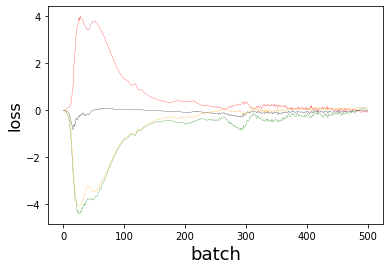

In [89]:
fig = plt.figure()
plt.plot([x[0] for x in gan.d_losses], color='black', linewidth=0.25)

plt.plot([x[1] for x in gan.d_losses], color='green', linewidth=0.25)
plt.plot([x[2] for x in gan.d_losses], color='red', linewidth=0.25)
plt.plot(gan.g_losses, color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)
plt.show()

## Generating images
Now we use our trained model to generate some images.

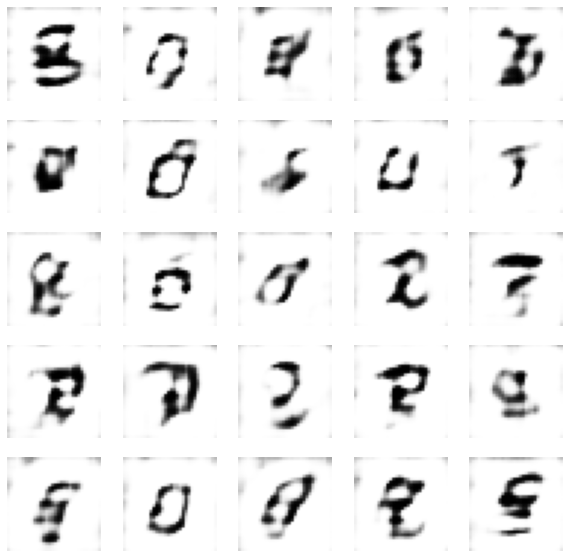

In [90]:
row_count, column_count = 5, 5
noise = np.random.normal(0, 1, (row_count * column_count, gan.z_dim))
gen_imgs = gan.generator.predict(noise)
gen_imgs = 0.5 * (gen_imgs + 1)
fig, axs = plt.subplots(row_count, column_count, figsize=(10,10))
for i in range(row_count):
    for j in range(column_count):
        axs[i,j].imshow(np.squeeze(gen_imgs[i * row_count + j, :,:,:]), cmap = 'gray_r')
        axs[i,j].axis('off')
plt.show()

## Conclusions
This images looks not bad, if we train more times and use higher resolution images, It can be more realistic.